<a href="https://colab.research.google.com/github/Davis-Moswedi/Music-Classification-By-Genre/blob/main/Music_Classification_By_Genre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Imports**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import io
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import plotly.express as px
import plotly.graph_objects as go
import math
import torch
from torch.nn import Linear, Tanh, Sigmoid, Module, BCELoss
from torch.optim import Adam
sns.set_theme(color_codes=True)
%matplotlib inline

## **Data Ingestion**

In [2]:
spotify_2000 = requests.get("https://raw.githubusercontent.com/Davis-Moswedi/Music-Classification-By-Genre/main/data/Spotify-2000.csv").content
spotify_2000 = pd.read_csv(io.StringIO(spotify_2000.decode('utf-8')))

In [3]:
data = spotify_2000.copy()
data.drop(axis=0, columns=['Index','Title', 'Year','Artist', 'Length (Duration)'], inplace=True)

## **Data Exploration and Analysis**

### **Check Null Values**

In [4]:
data[data.isna().any(axis=1)]

,Top Genre,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Acousticness,Speechiness,Popularity


### **First five rows of the data**

In [5]:
data.head()

,Top Genre,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Acousticness,Speechiness,Popularity
0,adult standards,157,30,53,-14,11,68,94,3,71
1,album rock,135,79,50,-11,17,81,17,7,39
2,alternative hip hop,168,69,66,-9,7,52,2,17,69
3,alternative metal,173,96,43,-4,3,37,0,4,76
4,classic rock,106,82,58,-5,10,87,1,3,59


### **The number of the classes**

In [6]:
print(len(data['Top Genre'].unique()))
data['Top Genre'].unique()

149


array(['adult standards', 'album rock', 'alternative hip hop',
       'alternative metal', 'classic rock', 'alternative pop rock', 'pop',
       'modern rock', 'detroit hip hop', 'alternative rock',
       'dutch indie', 'garage rock', 'dutch cabaret', 'permanent wave',
       'classic uk pop', 'dance pop', 'modern folk rock', 'dutch pop',
       'dutch americana', 'alternative dance', 'german pop', 'afropop',
       'british soul', 'irish rock', 'disco', 'big room', 'art rock',
       'danish pop rock', 'neo mellow', 'britpop', 'boy band',
       'carnaval limburg', 'arkansas country', 'latin alternative',
       'british folk', 'celtic', 'chanson', 'celtic rock', 'hip pop',
       'east coast hip hop', 'dutch rock', 'blues rock', 'electro',
       'australian pop', 'belgian rock', 'downtempo', 'reggae fusion',
       'british invasion', 'finnish metal', 'canadian pop', 'bow pop',
       'dutch hip hop', 'dutch metal', 'soft rock', 'acoustic pop',
       'acid jazz', 'dutch prog', 'ca

### **Checking outliers**


In [7]:
dataset = data.drop(axis=0, columns=['Top Genre'])
fig = go.Figure()
for i in dataset.columns:
  fig.add_traces(go.Box(y = dataset[i],name=i))
fig.update_layout(autosize=False,width=1200,height=750)
fig.show()

### **removing outliers**

In [8]:
column_names = ['Beats Per Minute (BPM)', 'Danceability', 'Loudness (dB)', 'Liveness', 'Speechiness', 'Popularity']
for column in column_names:
  Q1 = dataset[column].quantile(0.25)
  Q3 = dataset[column].quantile(0.75)
  IQR = Q3 - Q1    #IQR is interquartile range. 
  filter = (dataset[column] >= Q1 - 1.5 * IQR) & (dataset[column] <= Q3 + 1.5 *IQR)
  outliers = dataset[column].loc[~filter].index
  dataset.drop(outliers,inplace=True)
fig = go.Figure()
for i in dataset.columns:
  fig.add_traces(go.Box(y = dataset[i],name=i))
fig.update_layout(autosize=False,width=1200,height=750)
fig.show()

### **Generalising the genres**
* Since the number of classes(genres) is alot we need to reduce it to a reasonably amount
* We use dendrogram to view the hierarchical clusters 

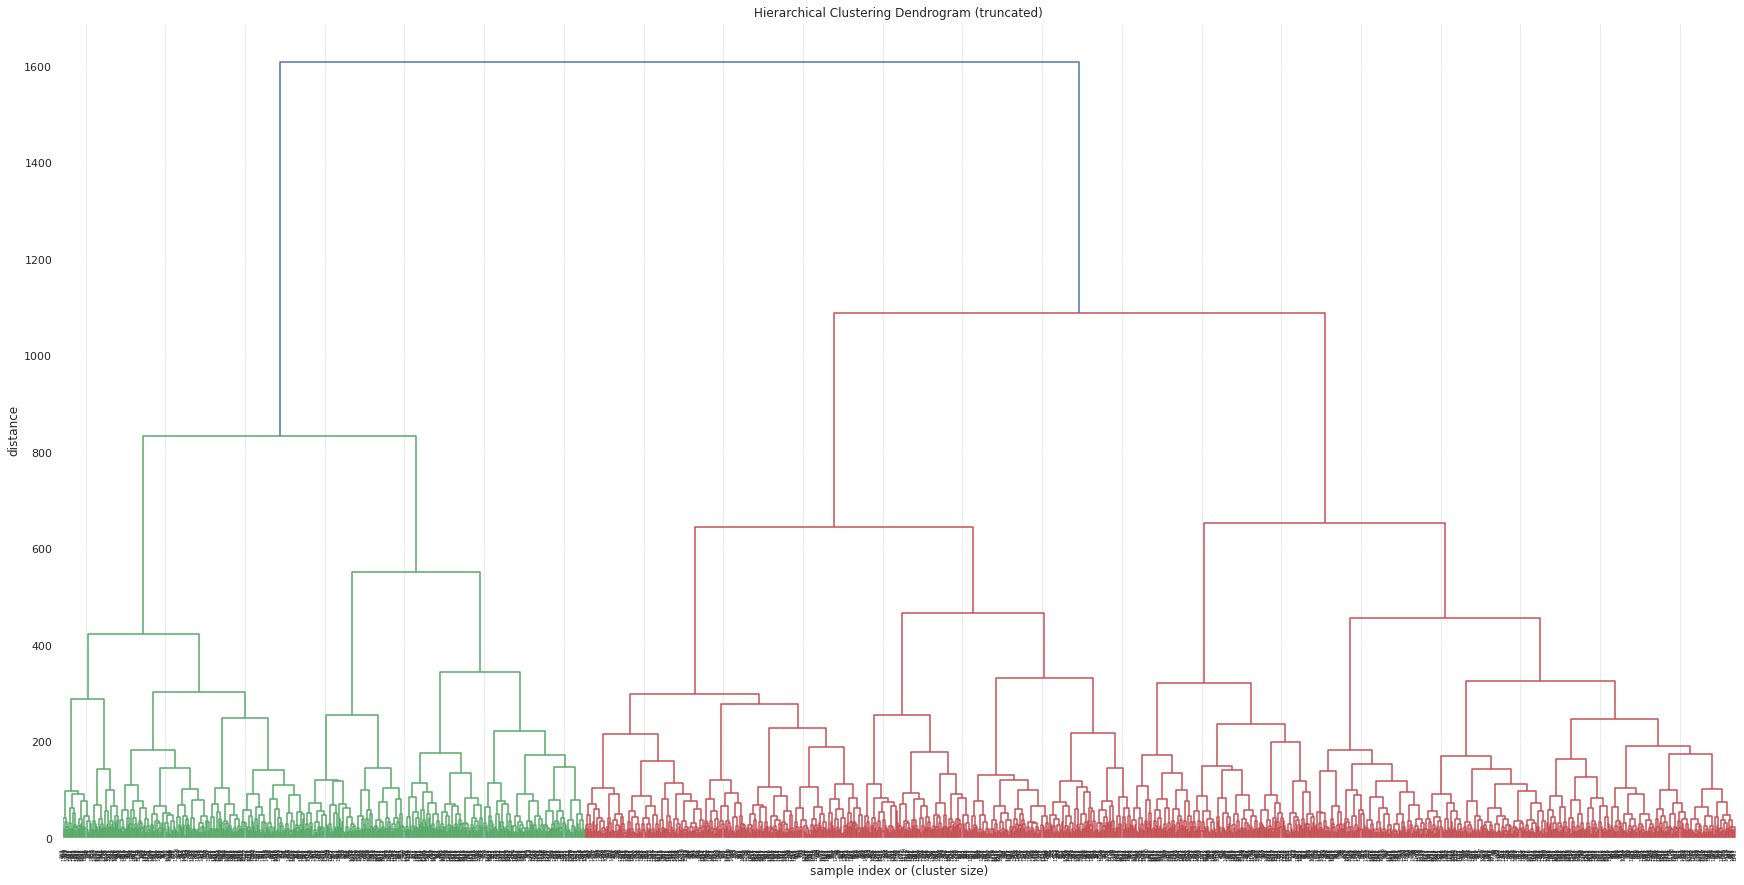

In [9]:
plt.figure(figsize=(30, 15))  
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance') 
dend = dendrogram(linkage(dataset, method='ward'))

* define a new dendrogram that can enable us to even set a cut off distance to cluster

In [10]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

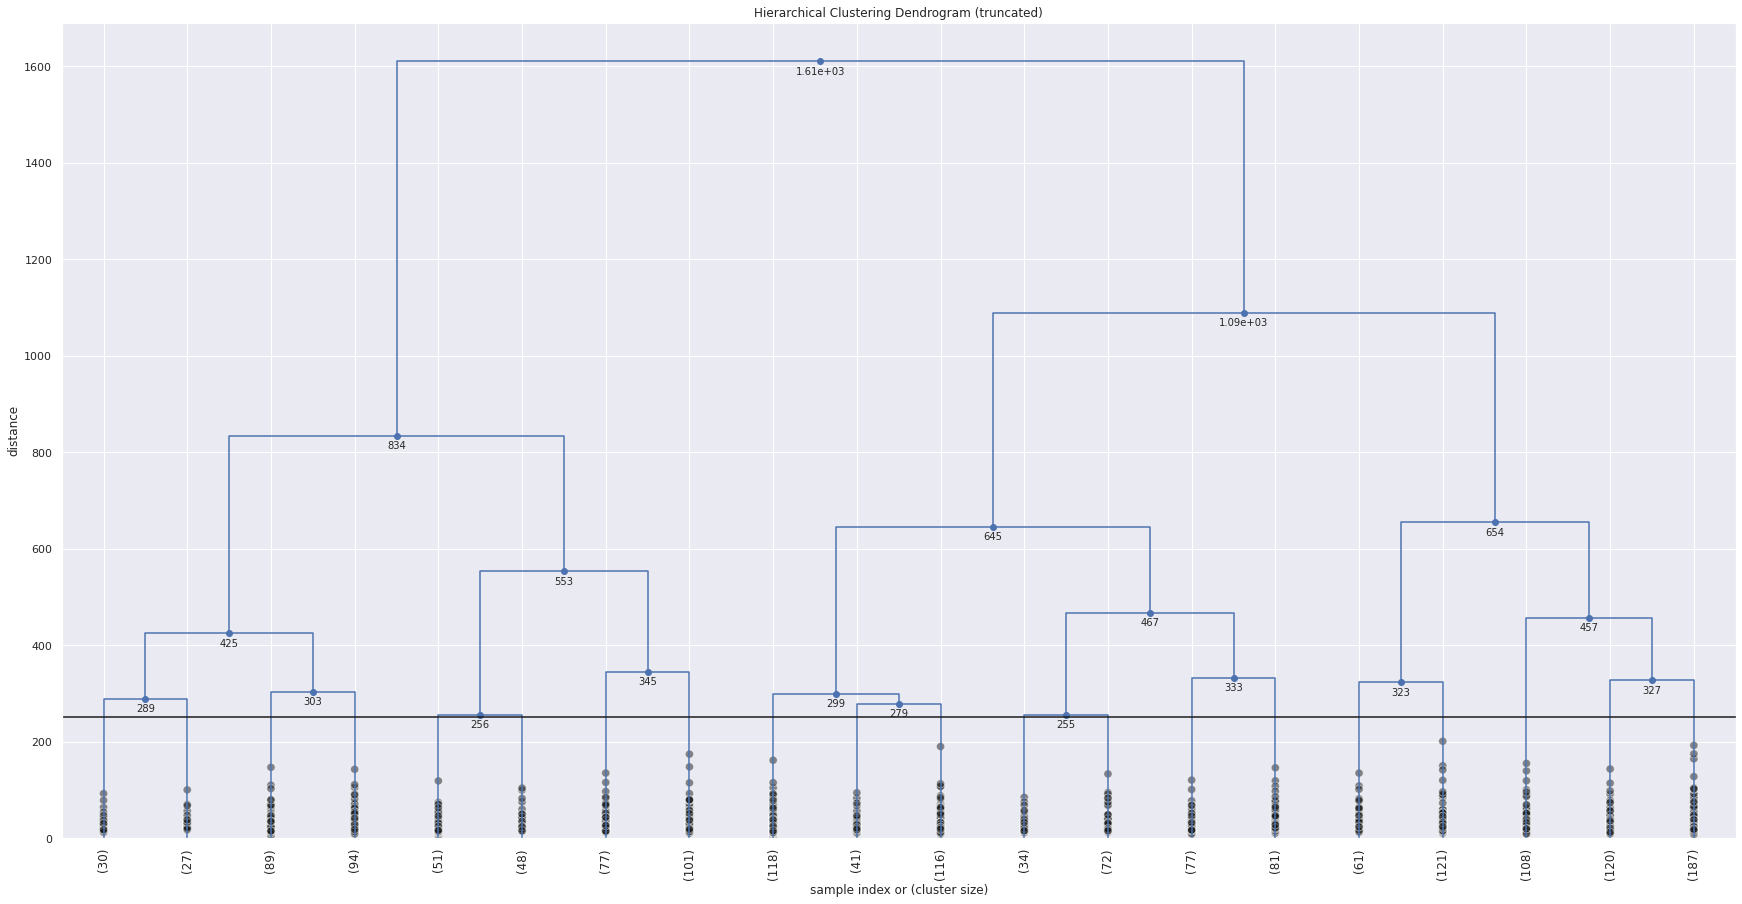

In [11]:
p = 20
Z = linkage(dataset, method='ward')
plt.figure(figsize=(30, 15))  
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=p,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
    max_d = 250
)
plt.show()

### **Retrieve clusters from dendrogram and add column in data indicating which clusters data point belong to**

In [12]:
# k defines the number of clusters
k = p
dataset['clusters'] = fcluster(Z, k, criterion='maxclust').tolist()
data.head()

,Top Genre,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Acousticness,Speechiness,Popularity
0,adult standards,157,30,53,-14,11,68,94,3,71
1,album rock,135,79,50,-11,17,81,17,7,39
2,alternative hip hop,168,69,66,-9,7,52,2,17,69
3,alternative metal,173,96,43,-4,3,37,0,4,76
4,classic rock,106,82,58,-5,10,87,1,3,59


### **Correlation matrix**


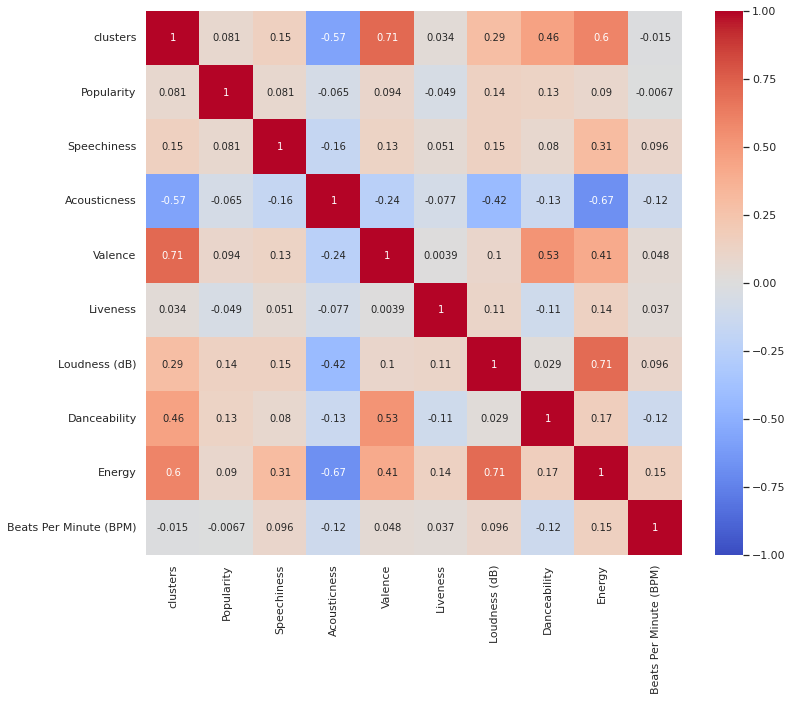

In [13]:
cols = list(dataset.columns)
cols.reverse()
plt.figure(figsize=[12,10])
sns.heatmap(dataset[cols].corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm');

### **View the clusters**

In [14]:
tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=2))])
genre_embedding = tsne_pipeline.fit_transform(dataset.drop(axis=1, columns=["clusters"]))
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = data.iloc[dataset.index]['Top Genre'].to_numpy()
projection['cluster'] = dataset['clusters'].to_numpy()
fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres'])
fig.update_layout(autosize=False,width=1000,height=750)
fig.show();

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1653 samples in 0.005s...
[t-SNE] Computed neighbors for 1653 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1653
[t-SNE] Computed conditional probabilities for sample 1653 / 1653
[t-SNE] Mean sigma: 0.876992
[t-SNE] Computed conditional probabilities in 0.099s
[t-SNE] Iteration 50: error = 76.1725006, gradient norm = 0.0319376 (50 iterations in 1.007s)
[t-SNE] Iteration 100: error = 75.0681534, gradient norm = 0.0359385 (50 iterations in 0.821s)
[t-SNE] Iteration 150: error = 74.8081207, gradient norm = 0.0179535 (50 iterations in 0.581s)
[t-SNE] Iteration 200: error = 74.8176270, gradient norm = 0.0252355 (50 iterations in 0.542s)
[t-SNE] Iteration 250: error = 74.8106232, gradient norm = 0.0214461 (50 iterations in 0.558s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.810623
[t-SNE] Iteration 300: error = 1.9143815, gradient norm = 0.0013979 (50 iterations in 0.581s)

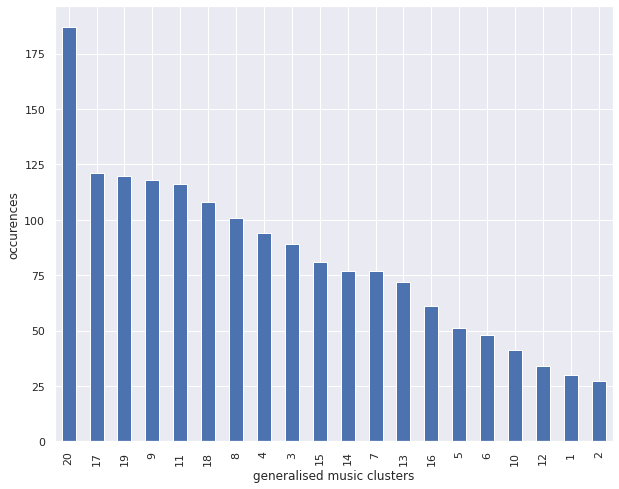

In [15]:
plt.figure(figsize=(10,8))
dataset['clusters'].value_counts().plot(kind='bar');
plt.xlabel("generalised music clusters")
plt.ylabel("occurences");

### **Music over time(years)**
Here we group the data by year and calculate the mean of each music features and plot the over the time(years). This will tell us how the music is evolving over the years

In [16]:
music_year_data = dataset.copy()
music_year_data['Year'] = spotify_2000.iloc[dataset.index]['Year'].to_numpy()
sound_features = ['Energy', 'Danceability', 'Liveness', 'Valence','Acousticness']
music_mean_year = music_year_data.groupby('Year').mean()
music_mean_year['x'] = music_mean_year.index
colors = px.colors.qualitative.Plotly
fig = go.Figure()
for i in range(len(sound_features)):
  fig.add_traces(go.Scatter(x=music_mean_year['x'], y = music_mean_year[sound_features[i]], mode = 'lines', line=dict(color=colors[i]),name=sound_features[i]))
fig.update_layout(autosize=False,width=1000,height=750)
fig.show()

## **Model Fitting**

In [17]:
dataset_y= dataset['clusters']

### **Standardise the data**

In [18]:
dataset_x = StandardScaler().fit_transform(dataset.drop(axis=1, columns=["clusters"]))

### **Train and Test data splitting**

In [19]:
trainX, testX, trainY, testY = train_test_split(dataset_x, dataset_y, test_size=0.2, random_state=4)

### **Logistic Regression**

In [20]:
logistic = LogisticRegression(C=1, penalty="l2", solver='newton-cg', random_state=5).fit(trainX, trainY)
logistic.score(testX, testY)

0.7643504531722054

### **Random Forest**

In [21]:
random_forest = RandomForestClassifier().fit(trainX, trainY)
random_forest.score(testX, testY)

0.8126888217522659

### **Naive Bayes**

In [22]:
gnb = GaussianNB().fit(trainX, trainY)
gnb.score(testX,testY)

0.7371601208459214